# Machine Learning for Time Series Data [Audio Focused]

**Aim**: The aim of this notebook is create a framework for predicting patterns based on time series data.

## Table of contents

1. Types & Applications of Time Series
2. Basics of ML
3. ML & Time series
4. Classifying a time series
5. Improving Features
6. The Spectogram
7. Regression Models
8. Cleaning data for regression models
9. Creating features for time series data
10. Creating features from the past
11. Cross Validating Time Series Data
12. Stationarity & Stability

### Package Requirements

In [437]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import librosa as lr
import numpy as np
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from functools import partial
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample

## Types & Applications of Time Series

**Key Notes**

- Time series needs 2 components: A data point & a time stamp. 
- Each datapoint can be uniquely identfied by a particular timestamp. 
- Timestamps can be in months, days, years or even nano-seconds. 

**Data**

The data used for this notebook is from: https://www.kaggle.com/camnugent/sandp500/version/4

In [3]:
df = pd.read_csv('/Users/kevin/datacamp/stocks.csv')

In [4]:
#Reducing the data size to the first 5000 rows for computational efficiency

df = df[:5000]

In [6]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


**Plotting the time series**

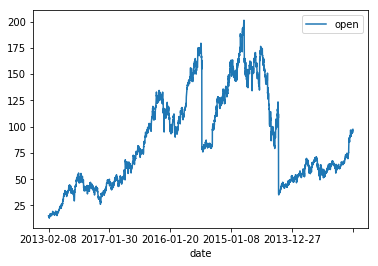

In [9]:
#Plotting the time series 

df.plot('date', 'open')
plt.show()

- You can plot multiple plot below each other using the code shown below

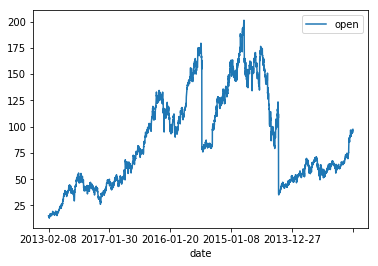

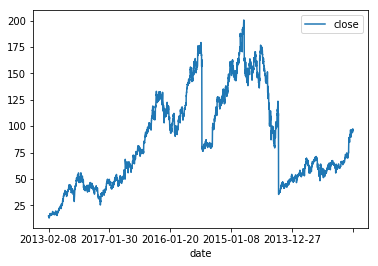

In [12]:
df.plot('date', 'open')
df.plot('date', 'close')
plt.show()

## Basics of ML

**Key Notes**

- Before analysis, take a look at the raw data.
- Scikit-learn is used thanks to it's robust API. 
- The dataframe has to be at least **2-D**. Samples x Features. 

In [13]:
df.shape

(5000, 7)

- The dataframe has 5000 samples x 7 features
- If your dataframe had (5000,)
- You would use the code shown below to reshape it.

df.reshape([-1,1]).shape

## ML & Time Series

**Data**

The data for this section comes from: https://www.kaggle.com/kinguistics/heartbeat-sounds/version/1

- The data is primarily based on heartbeat sound data and is thus .wav files

In [17]:
files = glob('/Users/kevin/Downloads/heartbeat-sounds/set_a/*.wav')

In [19]:
print(files[:5])

['/Users/kevin/Downloads/heartbeat-sounds/set_a/normal__201108011112.wav', '/Users/kevin/Downloads/heartbeat-sounds/set_a/Aunlabelledtest__201108222228.wav', '/Users/kevin/Downloads/heartbeat-sounds/set_a/artifact__201012172012.wav', '/Users/kevin/Downloads/heartbeat-sounds/set_a/extrahls__201104140118.wav', '/Users/kevin/Downloads/heartbeat-sounds/set_a/Aunlabelledtest__201106031556.wav']


**Extracting features from this dataset**

- We extract two sets of information.
- The audio is each data point in the audiofile.
- The sfreq is the sampling frequency

In [21]:
audio, sfreq = lr.load('/Users/kevin/Downloads/heartbeat-sounds/set_a/artifact__201012172012.wav')

In [22]:
print(audio)
print(sfreq)

[  2.29600846e-05  -1.29823224e-04  -1.80705130e-04 ...,  -1.16254902e-04
  -2.91645083e-05   2.91716224e-05]
22050


- The 'sfreq' is also known as the Sampling Frequency
- We have 22050 samples/second.
- If we know the sampling frequency we will know the timestamp of each data point relative to the first datapoint.

**Creating a time array**

**Option 1**

In [77]:
indices = np.arange(0, len(audio))
time = indices/sfreq

**Visualizing the time series data from the audio file**

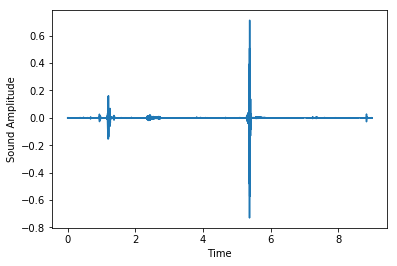

In [78]:
plt.plot(time,audio)
plt.xlabel('Time')
plt.ylabel('Sound Amplitude')
plt.show()

**Creating a time array for the stock data**

In [62]:
df = pd.read_csv('/Users/kevin/datacamp/stocks.csv')

In [63]:
df = df[:5000]

In [65]:
df['date'] = pd.to_datetime(df['date'])

In [66]:
df.index = pd.to_datetime(df['date'])

In [67]:
df = df[['open', 'low']]

**Visualizing the time series data for multiple columns**

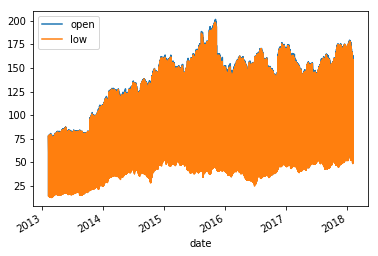

In [68]:
fig, ax = plt.subplots()

for column in df.columns:
    
    df[column].plot(ax=ax, label=column)
    
ax.legend()
plt.show()

## Classifying a time series

**Key Notes**

- Start with feature engineering. 
- Create features with summary statistics. 

**Creating statistical features for audio data**

- So for each audio file you can calculate statistical features and use them as a feature.
- Here we calculate the mean of one audio file.

In [79]:
mean = np.mean(audio, axis = -1)
max = np.max(audio, axis = -1)
stds = np.std(audio, axis = -1)

**Creating an audio file**

- In order to create an audio file we will combine the 'time' & the 'audio' arrays into a single array

**Sound file 1**

In [109]:
audio1, sfreq1 = lr.load('/Users/kevin/Downloads/heartbeat-sounds/set_a/artifact__201012172012.wav')

In [121]:
indices = np.arange(0, len(audio1))
time = indices/sfreq1

**Sound file 2**

In [113]:
audio2, sfreq2 = lr.load('/Users/kevin/Downloads/heartbeat-sounds/set_a/artifact__201105040918.wav')

In [122]:
indices = np.arange(0, len(audio2))
time = indices/sfreq2

In [123]:
audio_data = np.column_stack((time, audio1, audio2))

In [124]:
audio_data.shape

(198450, 3)

In [125]:
audio_df = pd.DataFrame(audio_data, columns= ['time', 'sound1', 'sound2'])

In [126]:
audio_df.index = audio_df['time']

In [127]:
audio_df = audio_df.drop('time', axis = 1)

In [128]:
audio_df.head()

,sound1,sound2
time,,
0.000000,0.000023,-0.000011
0.000045,-0.000130,0.000001
0.000091,-0.000181,0.000002
0.000136,-0.000167,-0.000002
0.000181,-0.000047,-0.000004


**Calculating summary statistical features**

In [129]:
mean_sound = np.mean(audio_df, axis=1)

In [131]:
mean_sound.shape

(198450,)

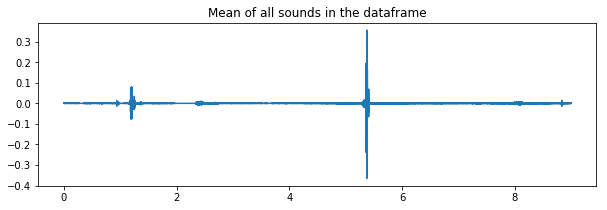

In [132]:
fig, ax1 = plt.subplots(1, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_sound)
ax1.set(title="Mean of all sounds in the dataframe")
plt.show()

- You can now use the mean of all the sounds as a feature called - Mean_class1
- This represents the mean of all the sounds that are classified in the 'Class1' category

## Improving features

- Here, you will find a list of features that you can use to further improve the performance of your audio data. 

**Auditory Envelope** - The total amount of audio energy present in a signal at any given time

- You first smooth out a noisy signal by doing a rolling average over a window.

**Example of extracting the rolling average of each sound**

In [142]:
window_size = 8
windowed = audio_df.rolling(window = window_size)
audio_df_smooth = windowed.mean()

In [143]:
audio_df_smooth.shape

(198450, 2)

In [145]:
audio_df_smooth.head(9)

,sound1,sound2
time,,
0.000000,NaN,NaN
0.000045,NaN,NaN
0.000091,NaN,NaN
0.000136,NaN,NaN
0.000181,NaN,NaN
0.000227,NaN,NaN
0.000272,NaN,NaN
0.000317,-0.000041,-1.341864e-06
0.000363,-0.000065,1.148577e-07


**Example of calculating the auditory average**

In [146]:
audio_rectified = audio_df.apply(np.abs)

In [178]:
audio_envelope = audio_rectified.rolling(50).mean()

In [179]:
audio_envelope.shape

(198450, 2)

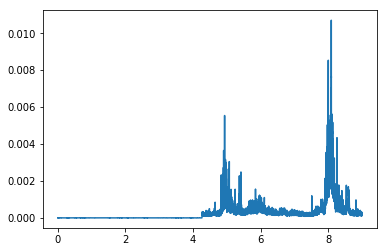

In [180]:
plt.plot(time, audio_envelope['sound2'])
plt.show()

**Creating statistical auditory envelope features**

In [159]:
envelope_mean = np.mean(audio_envelope, axis = 0)
envelope_max = np.max(audio_envelope, axis = 0)
envelope_std = np.std(audio_envelope, axis = 0)

In [160]:
training_data = np.column_stack([envelope_mean, envelope_max, envelope_std])

In [161]:
training_data

array([[  1.30660657e-03,   6.27129469e-01,   1.38543746e-02],
       [  2.95921969e-04,   1.53066444e-02,   7.16380429e-04]])

- Each row can then be labelled as such. 
- The first row can belong to sounds of one type of category.
- The second row can belong to sounds of another type and so on.

**Creating labels**

In [166]:
labels = np.array(([0], [1]))

In [167]:
labels

array([[0],
       [1]])

**Tempogram** - Estimates the tempo of sound over time

In [181]:
audio_temp = lr.beat.tempo(audio1, sr = sfreq1, hop_length = 2**6, aggregate = None)

In [187]:
tempo_mean = np.mean(audio_temp, axis = 0)
tempo_max = np.max(audio_temp, axis = 0)
tempo_std = np.std(audio_temp, axis = 0)

In [188]:
training_data = np.column_stack([tempo_mean, tempo_max, tempo_std])

In [189]:
training_data

array([[ 117.41492317,  136.89983444,   21.0627475 ]])

## The Spectogram

**Key Notes**

- The spectogram is a collection of windowed Fourier Transforms taken over time
- This is called a Short Time Fourier Transform (STFT)
- You can then use the STFT as a feature 

**Exmaple of visualizing the spectogram for an audio file**

In [191]:
audio_spec = stft(audio1, hop_length = 2**4, n_fft = 2**7)

In [197]:
spec_db = amplitude_to_db(audio_spec)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


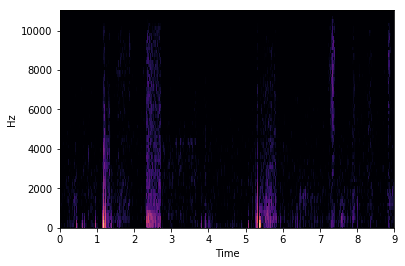

In [199]:
specshow(spec_db, sr = sfreq1, x_axis = 'time', y_axis = 'hz', hop_length = 2**4)
plt.show()

**Example of generating features using spectograms**

In [214]:
# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(audio, hop_length=HOP_LENGTH, n_fft=2**7)

In [217]:
bandwidths = lr.feature.spectral_bandwidth(S=np.abs(spec).real)

In [247]:
centroids = lr.feature.spectral_centroid(S= np.abs(spec).real)

**Extracting statistical features from the spectral features**

In [256]:
centroid_mean = centroids.mean()

In [257]:
bandwidth_mean = bandwidths.mean()

In [258]:
training_data = np.column_stack([centroid_mean, bandwidth_mean])

In [260]:
training_data

array([[ 3692.96424508,  2780.31278607]])

## Regression Models 

Using the stock data to build regression models 

In [263]:
df = pd.read_csv('/Users/kevin/datacamp/stocks.csv')

In [264]:
df = df[:5000]

In [265]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


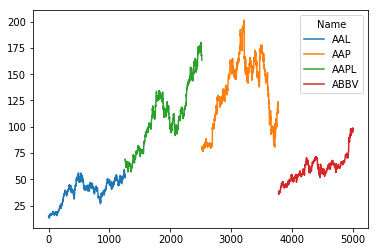

In [269]:
df.set_index('Name',append=True).unstack()['high'].plot()
plt.show()

**Scatter plot of the time series**

- In this section we plot the Opening & Closing prices on the X & Y axis by modelling time using a color map.
- This will give us information about the correlation between the two variables.

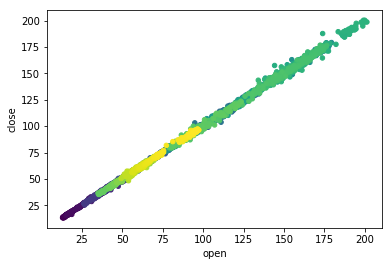

In [271]:
# Scatterplot with color relating to time
df.plot.scatter('open', 'close', c= df.index, cmap= plt.cm.viridis, colorbar=False)
plt.show()

In the plot above:
    
- The change in color represents the change of time.
- Purple starts off at an earlier point in time while the green dots signify a later point in time. 
- Finally, the plot is positively correlated over time.

**Building & visualizing the linear regression model**

In [275]:
#Extracting training data inputs & outputs
X = df[['open', 'high']]
y = df[['low']]

In [276]:
# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[ 0.99925279  0.99804935  0.99946406]


In [278]:
# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False, random_state=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [279]:
# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

0.994904722882


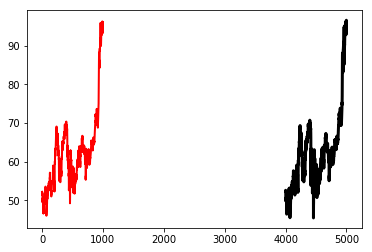

In [292]:
# Visualize our predictions along with the "true" values, and print the score

plt.plot(y_test, color='k', lw=3)
plt.plot(predictions, color='r', lw=2)
plt.show()

- The red plot represents the predicted values. 
- The black plot represents the actual values.

## Cleaning data for regression models 

**Dealing with missing data**

- When data is missing from a time series you can fille it up using a technique known as interpolation

In [296]:
df.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

- There is no missing data
- But if a column did have missing data, we would use the following stategy for interpolation

In [297]:
interpol = df['open'].interpolate('linear')

- You can then plot the interpolated plot by using the code shown below

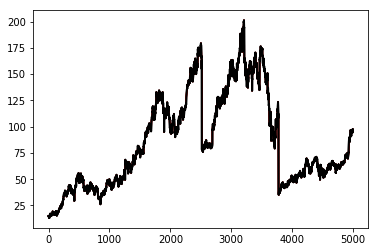

In [300]:
ax = interpol.plot(c = 'r')
df['open'].plot(c = 'k', ax = ax, lw = 2)
plt.show()

- If there was missing data the interpolated lines will appear in 'red'

**Standardizing the data by using the percentage change between sucessive points in time**

In [303]:
def percent_change(values):
    
    """Calculate Percentage change between last value & the mean of the previous values"""
    previous_values = values[:-1]
    last_value = values[-1]
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

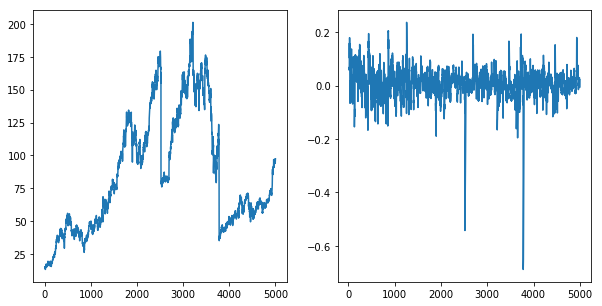

In [307]:
fig, axs = plt.subplots(1,2, figsize = (10, 5))
ax = df['open'].plot(ax = axs[0])

ax = df['open'].rolling(window = 20).aggregate(percent_change).plot(ax = axs[1])
plt.show()

- On the left you have the data pre-standardization.  
- On the right you have the data post-standardization.
- Observe how it is all centered around the mean
- This helps you detect outliers.

**Identifying outliers in your time series data**

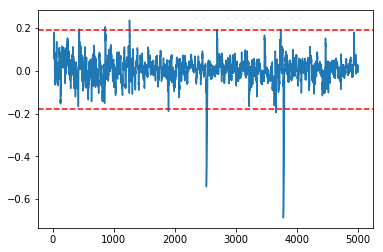

In [326]:
#Extract the mean and std for the data 
    
this_mean = df['open'].rolling(window = 20).aggregate(percent_change).mean()
this_std = df['open'].rolling(window = 20).aggregate(percent_change).std()
    
#Plot the data with a window of 3 stds from the mean to find the outliers 
df['open'].rolling(window = 20).aggregate(percent_change).plot()
plt.axhline(this_mean + this_std*3, ls = '--', c = 'r')
plt.axhline(this_mean - this_std*3, ls = '--', c = 'r')
plt.show()

**Replacing the outliers in your data with the median value**

In [327]:
percent_change = df['open'].rolling(window = 20).aggregate(percent_change)

In [328]:
#Center the data so mean is 0

percent_change_centered = percent_change - percent_change.mean()

#Extract std 

std = percent_change.std()

#Use abs value to find outliers easily 

outliers = np.abs(percent_change_centered) > (std * 3)

#Replace outliers with median value 

percent_change_no_outliers = percent_change_centered.copy()

percent_change_no_outliers[outliers] = np.nanmedian(percent_change_no_outliers)

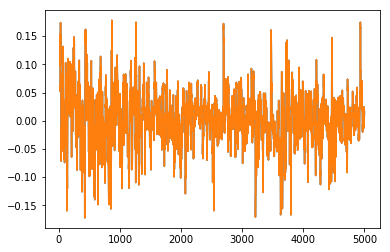

In [331]:
percent_change_no_outliers.plot()
plt.show()

- You can now observe that the outliers are fixed.

## Creating features for time series data

- Extracting statistical features using a rolling window is the best way to extract multiple features at once.

**Example of extracting statistical features**

In [334]:
df.index = df['date']

In [335]:
df.head(2)

,date,open,high,low,close,volume,Name
date,,,,,,,
2013-02-08,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL


In [336]:
df_feat = df.drop(['date', 'Name'], axis = 1)

In [337]:
df_feat = df_feat.rolling(20).aggregate([np.std, np.max]).dropna()

In [339]:
df_feat.head(2)

open             high             low            close         \
                 std   amax       std  amax       std   amax       std   amax   
date                                                                            
2013-03-08  0.627269  15.07  0.579276  15.2  0.632807  14.84  0.599086  14.92   
2013-03-11  0.610960  14.99  0.581433  15.2  0.639206  14.84  0.629145  15.13   

                  volume              
                     std        amax  
date                                  
2013-03-08  5.661578e+06  31879900.0  
2013-03-11  5.701201e+06  31879900.0

**Extracting Percentiles as a feature**

- Percentiles are a good way to generate summaries of data in a column
- For example, The 60th percentile is value where 60% of the data is below that datapoint & 40% of the data is above that datapoint.

In [341]:
np.percentile(np.linspace(0,100), q = 25)

25.0

- In the example above you have calculated the value for the 25th percentile in a range of numbers from 0 to 25

**Example of computing the percentile for a column**

In [360]:
data = df['open']

In [367]:
percentiles = [1, 10, 25, 50, 75]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = data.rolling(20, min_periods=5)
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

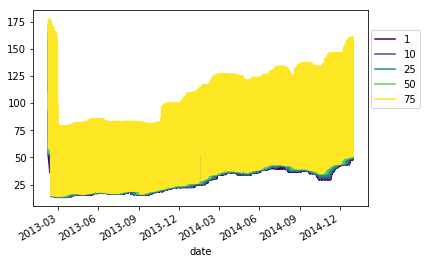

In [371]:
# Plot a subset of the result
ax = features_percentiles.loc["2013":"2014"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

**Example of extracting date-based features**

- Since most time series are based off human-generated data dates are significant for generating patterns.
- Dates like holidays, or speicial events will generate different results which we can then use as inputs for prediction.

In [355]:
df.index = pd.to_datetime(df.index)
day_of_week_number = df.index.weekday
day_of_week_number[:5]

Int64Index([4, 0, 1, 2, 3], dtype='int64', name='date')

In [356]:
day_of_week = df.index.weekday_name
day_of_week[:5]

Index(['Friday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'], dtype='object', name='date')

In [372]:
df['month_of_year'] = df.index.month

In [374]:
df['day_of_week'] = df.index.dayofweek

In [375]:
df['week_of_year'] = df.index.weekofyear

In [376]:
df.head(2)

,date,open,high,low,close,volume,Name,month_of_year,day_of_week,week_of_year
date,,,,,,,,,,
2013-02-08,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2,4,6
2013-02-11,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2,0,7


## Creating features from the past

- Since the data in a time series follows the linear progression of time the past is useful in predicting the future.
- Import to understand how smooth the data is over time.
- Smoothness referes to how correlated each data point is with it's neighbors - Auto-correlation

In [377]:
## Shifting the datapoints 3 indexes to the past.

df['open'].shift(3)

date
2013-02-08      NaN
2013-02-11      NaN
2013-02-12      NaN
2013-02-13    15.07
2013-02-14    14.89
2013-02-15    14.45
2013-02-19    14.30
2013-02-20    14.94
2013-02-21    13.93
2013-02-22    14.33
2013-02-25    14.17
2013-02-26    13.62
2013-02-27    13.57
2013-02-28    13.60
2013-03-01    13.14
2013-03-04    13.28
2013-03-05    13.49
2013-03-06    13.37
2013-03-07    13.50
2013-03-08    14.01
2013-03-11    14.52
2013-03-12    14.70
2013-03-13    14.99
2013-03-14    14.85
2013-03-15    15.14
2013-03-18    15.54
2013-03-19    15.98
2013-03-20    16.45
2013-03-21    15.80
2013-03-22    16.48
              ...  
2017-11-02    91.70
2017-11-03    90.88
2017-11-06    90.78
2017-11-07    92.08
2017-11-08    91.30
2017-11-09    92.22
2017-11-10    92.98
2017-11-13    94.31
2017-11-14    95.29
2017-11-15    95.35
2017-11-16    95.37
2017-11-17    94.64
2017-11-20    94.63
2017-11-21    94.44
2017-11-22    93.80
2017-11-24    93.92
2017-11-27    93.70
2017-11-28    94.69
2017-11-29    9

In [378]:
data = df['open']

In [397]:
#Shifting the data by a couple (0,1,2,3) days

shifts = [0,1,2,3]

#Creating a dictionary of time shifted data

many_shifts = {'lag_{}'.format(ii): data.shift(ii) for ii in shifts}

# Convert them into a dataframe 

many_shifts = pd.DataFrame(many_shifts)

In [398]:
many_shifts.head()

,lag_0,lag_1,lag_2,lag_3
date,,,,
2013-02-08,15.07,NaN,NaN,NaN
2013-02-11,14.89,15.07,NaN,NaN
2013-02-12,14.45,14.89,15.07,NaN
2013-02-13,14.30,14.45,14.89,15.07
2013-02-14,14.94,14.30,14.45,14.89


**Visualizing the shifted data**

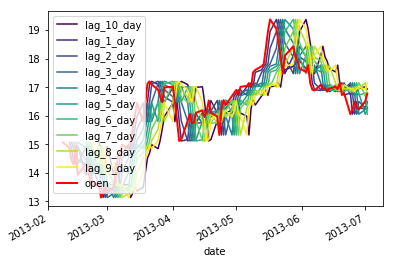

In [395]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): data.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
data_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = data_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
data.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

**Fitting a model on the shifted data**

In [396]:
data = df['open']

In [399]:
X = many_shifts.fillna(np.nanmedian(many_shifts))
y = data.fillna(np.nanmedian(data))

In [404]:
y.isna().sum()

0

In [400]:
model = Ridge()

In [405]:
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

**Assessing feature importance using the time shifted data**

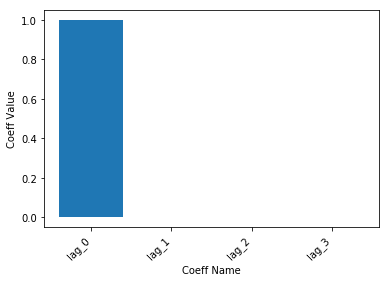

In [406]:
fig, ax = plt.subplots()
ax.bar(many_shifts.columns, model.coef_)
ax.set(xlabel = 'Coeff Name', ylabel = 'Coeff Value')

plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

## Cross Validating Time Series Data

- A key point when testing the performance of time series predictions using cross validation is that you should not shuffle your data as it is not identically & independantly distributed.

In [415]:
X = df['open'].reshape(-1, 1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [416]:
y = df['close']

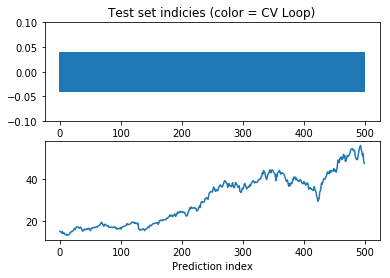

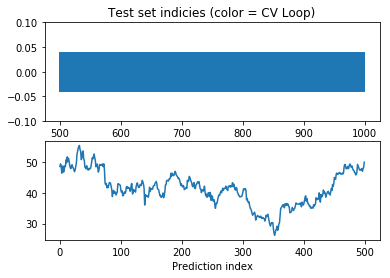

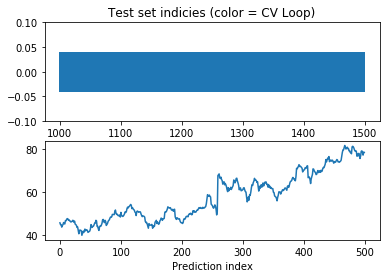

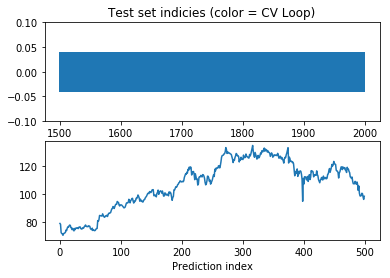

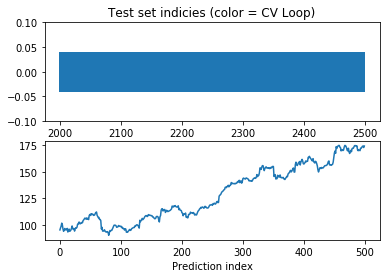

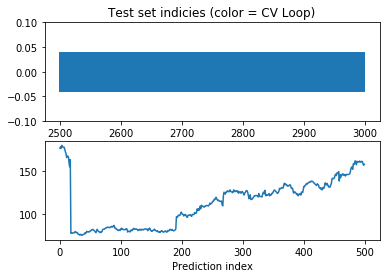

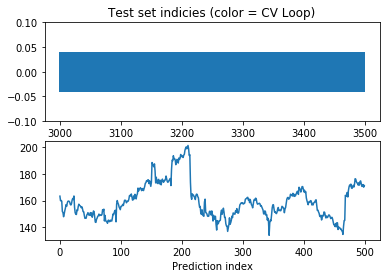

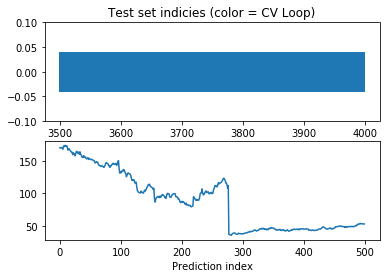

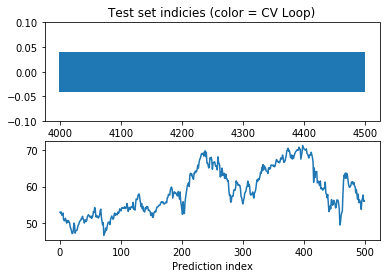

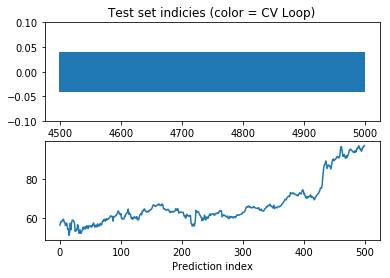

In [423]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, tt))
    
    fig, axs = plt.subplots(2,1)

    axs[0].scatter(tt, [0] * len(tt), marker = '_', s = 2, lw = 40)
    axs[0].set(ylim = [-.1, .1], title = 'Test set indicies (color = CV Loop)', xlabel = 'Index of raw data')
    
    axs[1].plot(model.predict(X[tt]))
    axs[1].set(xlabel = "Prediction index")
    
    plt.show()

**Visualizing the training data used in each cross validated test set**

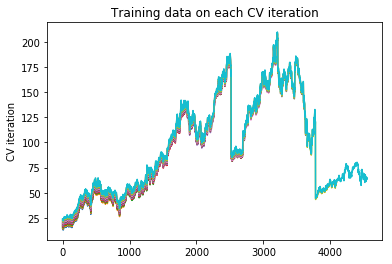

In [426]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

## Stationarity & Stability

- A stationary time series is one which does not change it's statistical properties over time. 
- Therefore, there are no trends or patterns that can be observed
- Most time series signals in the real world are non-stationary in nature 
- Non stationary signals result in a lot of variability in the model output. 
- Therefore it is a good practise to quantfy or assess the variability in the model first.
- Variability in the model is bad because we want our model to give us consistent predictions everytime.
- Cross Validation Model coeffs across each CV split can be used to assess model stability. If it varys across every split that the model is not stable. 
- You can also bootstrap the mean.

**Example of bootstrapping the mean**

In [430]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [431]:
data = df['open']

In [432]:
bootstrap_interval(data)

array([[ 84.0636334 ,  84.0636334 ,  84.0636334 , ...,  84.0636334 ,
         84.0636334 ,  84.0636334 ],
       [ 86.13717313,  86.13717313,  86.13717313, ...,  86.13717313,
         86.13717313,  86.13717313]])

**Example of calculating the variablity in the model coeffs**

In [433]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

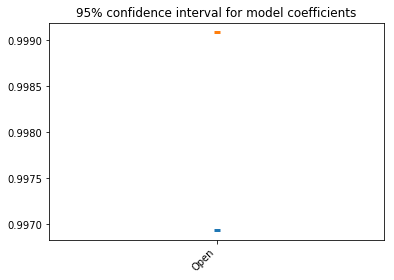

In [436]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter('Open', bootstrapped_interval[0], marker='_', lw=3)
ax.scatter('Open', bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

**Example of improving model performance by reducing the variability in coeffs by using a window**

In [458]:
def my_pearsonr(model, X, y):
    
    return np.corrcoef(y, model.predict(X))[1, 0]

In [459]:
times_scores = [df.index[tt[0]] for tr, tt in cv.split(X, y)]

In [460]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

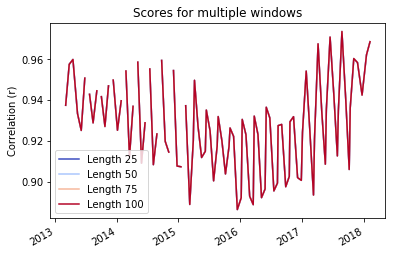

In [462]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()

### tsfresh is an advanced machine learning package that lets you extract more advanced features from time series data

### Quantopian is a platform where you can learn the predictive models that experts have built for financial time series